In [66]:
import transformers
from transformers import ByT5Tokenizer, T5ForConditionalGeneration, T5Config
import torch
import seaborn as sns
from tqdm import tqdm
import numpy as np
import math
import gc
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats


#from src.myt5_tokenizer import MyT5|Tokenizer

In [80]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['mathtext.fontset'] = 'cm'
# bigger size
mpl.rcParams['font.size'] = 20
# bold x-labels
mpl.rcParams['axes.labelweight'] = 'bold'
# smaller labels on axes
mpl.rcParams['axes.labelsize'] = 20

mpl.rcParams['xtick.labelsize'] = 20

## Load Data Computed on Cluster

In [87]:
LM_RESULT_DIR ="../flores200_lm_results"

model_types = ("myt5", "byt5")
model_sizes = ("small", "base", "large")

bpeb = pd.DataFrame()
bpeb_avg =  pd.DataFrame()

bpeb_unseen = pd.DataFrame()
bpeb_unseen_avg = pd.DataFrame()
comp = pd.DataFrame()
comp_avg = pd.DataFrame()
times = pd.DataFrame()
times_avg = pd.DataFrame()
for mt in model_types:
    for ms in model_sizes:
        bpeb = pd.concat([bpeb, pd.read_csv(f"{LM_RESULT_DIR}/{mt}_{ms}_bpeb.csv")])
        bpeb_avg = pd.concat([bpeb_avg, pd.read_csv(f"{LM_RESULT_DIR}/{mt}_{ms}_bpeb_avg.csv")])
        comp = pd.concat([comp, pd.read_csv(f"{LM_RESULT_DIR}/{mt}_{ms}_comp.csv")])
        comp_avg = pd.concat([comp_avg, pd.read_csv(f"{LM_RESULT_DIR}/{mt}_{ms}_comp_avg.csv")])
        times = pd.concat([times, pd.read_csv(f"{LM_RESULT_DIR}/{mt}_{ms}_times.csv")])
        times_avg = pd.concat([times_avg, pd.read_csv(f"{LM_RESULT_DIR}/{mt}_{ms}_times_avg.csv")])
    bpeb_unseen = pd.concat([bpeb_unseen, pd.read_csv(f"{LM_RESULT_DIR}/{mt}_large_unseen_bpeb.csv")])
    bpeb_unseen_avg = pd.concat([bpeb_unseen_avg, pd.read_csv(f"{LM_RESULT_DIR}/{mt}_large_unseen_bpeb_avg.csv")])

# bpeb_unseen = bpeb_unseen.drop(bpeb_unseen[bpeb_unseen.Language == 'en'].index)
# bpeb_unseen_avg = bpeb_unseen_avg.drop(bpeb_unseen_avg[bpeb_unseen_avg.Language == 'en'].index)


## Load Flores Dataset for some language

In [69]:
# load flores dataset for languages: en, es, pt, fr, it, ro, pl, mt, ja, zh, ko, te, ta

# language sample
language_sample = ['ta', 'te', 'el', 'hy', 'ru', 'kk', 'am', 'vi', 'ja', 'fr', 'sm', 'st', 'ko', 'de', 'mt', 'pl', 'sn', 'en']
language_all = comp_avg[comp_avg.Model == "myt5_small"]["Language"].values
#palette = sns.color_palette("viridis", len(languages))
#languages_colors = {lang: col for lang, col in zip(languages, palette)}
nice_colors = [ ]



# use the code from above to get the flores200 languages
# Latin / Corsican / Hawaiian language not in Flores
languages_flores = {'en': 'eng_Latn', 'ceb': 'ceb_Latn', 'de': 'deu_Latn', 'sv': 'swe_Latn', 'fr': 'fra_Latn', 'nl': 'nld_Latn', 'ru': 'rus_Cyrl', 'es': 'spa_Latn',
                    'it': 'ita_Latn', 'pl': 'pol_Latn', 'ja': 'jpn_Jpan', 'zh': 'zho_Hans', 'uk': 'ukr_Cyrl', 'vi': 'vie_Latn', 'ar': 'arb_Arab',
                    'pt': 'por_Latn', 'fa': 'pes_Arab', 'ca': 'cat_Latn', 'sr': 'srp_Cyrl', 'id': 'ind_Latn', 'ko': 'kor_Hang', 'no': 'nob_Latn',
                    'fi': 'fin_Latn', 'tr': 'tur_Latn', 'cs': 'ces_Latn', 'hu': 'hun_Latn', 'ro': 'ron_Latn', 'eu': 'eus_Latn', 'ms': 'zsm_Latn',
                    'eo': 'epo_Latn', 'he': 'heb_Hebr', 'hy': 'hye_Armn', 'da': 'dan_Latn', 'bg': 'bul_Cyrl', 'cy': 'cym_Latn', 'sk': 'slk_Latn',
                    'uz': 'uzn_Latn', 'et': 'est_Latn', 'be': 'bel_Cyrl', 'kk': 'kaz_Cyrl', 'el': 'ell_Grek', 'lt': 'lit_Latn', 'gl': 'glg_Latn',
                    'ur': 'urd_Arab', 'az': 'azj_Latn', 'sl': 'slv_Latn', 'ka': 'kat_Geor', 'hi': 'hin_Deva', 'th': 'tha_Thai', 'ta': 'tam_Taml',
                    'bn': 'ben_Beng', 'mk': 'mkd_Cyrl',  'lv': 'lvs_Latn', 'af': 'afr_Latn', 'tg': 'tgk_Cyrl', 'my': 'mya_Mymr',
                    'mg': 'plt_Latn', 'sq': 'als_Latn', 'mr': 'mar_Deva', 'te': 'tel_Telu', 'ml': 'mal_Mlym', 'ky': 'kir_Cyrl', 'sw': 'swh_Latn',
                    'jv': 'jav_Latn', 'ht': 'hat_Latn', 'lb': 'ltz_Latn', 'su': 'sun_Latn', 'ku': 'kmr_Latn', 'ga': 'gle_Latn', 'is': 'isl_Latn',
                    'fy': 'fao_Latn', 'pa': 'pan_Guru', 'yo': 'yor_Latn', 'ne': 'npi_Deva', 'ha': 'hau_Latn', 'kn': 'kan_Knda', 'gu': 'guj_Gujr',
                    'mn': 'khk_Cyrl', 'ig': 'ibo_Latn', 'si': 'sin_Sinh', 'ps': 'pbt_Arab', 'gd': 'gla_Latn', 'sd': 'snd_Arab', 'yi': 'ydd_Hebr',
                    'am': 'amh_Ethi', 'sn': 'sna_Latn', 'zu': 'zul_Latn', 'km': 'khm_Khmr', 'so': 'som_Latn', 'mi': 'mri_Latn',
                    'mt': 'mlt_Latn', 'lo': 'lao_Laoo', 'xh': 'xho_Latn', 'sm': 'smo_Latn', 'ny': 'nya_Latn', 'st': 'sot_Latn',
                    'ast': 'ast_Latn', 'war': 'war_Latn', 'aeb': 'aeb_Arab', 'sa': 'san_Deva', 'sal': 'sat_Olck'}


flores = {}

for lang in language_all:
    with open(f'../flores200_dataset/devtest/{languages_flores[lang]}.devtest', 'r') as f:
        flores[lang] = f.read().splitlines()

In [70]:



LANGUAGE_TO_SCRIPT = {'af': 'Latn', 'am': 'Ethi', 'ar': 'Arab', 'az': 'Latn', 'be': 'Cyrl', 'bg': 'Cyrl', 'bn': 'Beng', 'ca': 'Latn',
                      'ceb': 'Latn', 'co': 'Latn', 'cs': 'Latn', 'cy': 'Latn', 'da': 'Latn', 'de': 'Latn', 'el': 'Grek', 'en': 'Latn', 
                      'eo': 'Latn', 'es': 'Latn', 'et': 'Latn', 'eu': 'Latn', 'fa': 'Arab', 'fi': 'Latn', 'fil': 'Latn', 'fr': 'Latn', 
                      'fy': 'Latn', 'ga': 'Latn', 'gd': 'Latn', 'gl': 'Latn', 'gu': 'Gujr', 'ha': 'Latn', 'haw': 'Latn', 'he': 'Hebr', 'hi': 'Deva',
                      'hmn': 'Latn', 'ht': 'Latn', 'hu': 'Latn', 'hy': 'Armn', 'id': 'Latn', 'ig': 'Latn', 'is': 'Latn', 'it': 'Latn', 
                      'iw': 'Hebr', 'ja': 'Japn', 'jv': 'Latn', 'ka': 'Geor', 'kk': 'Cyrl', 'km': 'Khmr', 'kn': 'Knda', 'ko': 'Kore', 
                      'ku': 'Latn', 'ky': 'Cyrl', 'la': 'Latn', 'lb': 'Latn', 'lo': 'Lao', 'lt': 'Latn', 'lv': 'Latn', 'mg': 'Latn',
                      'mi': 'Latn', 'mk': 'Cyrl', 'ml': 'Mlym', 'mn': 'Cyrl', 'mr': 'Deva', 'ms': 'Latn', 'mt': 'Latn', 'my': 'Mymr', 
                      'ne': 'Deva', 'nl': 'Latn', 'no': 'Latn', 'ny': 'Latn', 'pa': 'Guru', 'pl': 'Latn', 'ps': 'Arab', 'pt': 'Latn',
                      'ro': 'Latn', 'ru': 'Cyrl', 'sd': 'Arab', 'si': 'Sinh', 'sk': 'Latn', 'sl': 'Latn', 'sm': 'Latn', 'sn': 'Latn',
                      'so': 'Latn', 'sq': 'Latn', 'sr': 'Cyrl', 'st': 'Latn', 'su': 'Latn', 'sv': 'Latn', 'sw': 'Latn', 'ta': 'Taml', 
                      'te': 'Telu', 'tg': 'Cyrl', 'th': 'Thai', 'tr': 'Latn', 'uk': 'Cyrl', 'ur': 'Arab', 'uz': 'Latn', 'vi': 'Latn', 'xh': 'Latn',
                      'yi': 'Hebr', 'yo': 'Latn', 'zh': 'Hans', 'zu': 'Latn'}
# more general script categories
SCRIPT_TO_CATEGORY = {'Latn': 'Latin', 'Ethi': 'Other', 'Arab': 'Abjad', 'Cyrl': 'Alphabetic', 'Beng': 'Abugida N', 'Grek': 'Alphabetic', 
                      'Deva': 'Abugida N', 'Gujr': 'Abugida N', 'Hebr': 'Abjad', 'Japn': 'CJK', 'Geor': 'Alphabetic', 'Khmr': 'Abugida S',
                      'Knda': 'Abugida S', 'Lao': 'Abugida S', 'Mlym': 'Abugida S', 'Mymr': 'Abugida S', 'Sinh': 'Abugida N', 'Taml': 'Abugida S',
                      'Telu': 'Abugida S', 'Thai': 'Abugida S', 'Hans': 'CJK', 'Hant': 'CJK', 'Kore': 'CJK', 'Armn': 'Alphabetic', 'Guru': 'Abugida N'}
LANGUAGE_TO_SCRIPT_CATEGORY = {lang: SCRIPT_TO_CATEGORY[script] for lang, script in LANGUAGE_TO_SCRIPT.items()}

palette = sns.color_palette("tab10", len(set(LANGUAGE_TO_SCRIPT_CATEGORY.values())))
palette = [palette[i] for i in [3, 0, 6, 1, 2, 4, 5]]
category_colors = {cat: col for cat, col in zip(['Latin', 'Alphabetic', 'Abjad', 'Abugida N', 'Abugida S', 'CJK', 'Other'], palette)}
language_colors = [category_colors[LANGUAGE_TO_SCRIPT_CATEGORY[lang]] for lang in language_sample]
language_all_colors = [category_colors[LANGUAGE_TO_SCRIPT_CATEGORY[lang]] for lang in language_all]

In [71]:

latin = ['en', 'de', 'sv', 'fr', 'nl', 'es', 'it', 'pl', 'vi', 'pt', 'ca', 'fi', 'tr', 'cs', 'hu', 'eu', 
         'ceb','id','no', 'ro', 'ms', 'eo', 'da', 'cy', 'sk', 'uz', 'et', 'lt', 'gl', 'az', 'sl', 'lv', 'af', 'mg', 'sq', 'sw', 'jv',
         'ht', 'lb', 'su', 'ku', 'ga', 'is', 'fy', 'yo', 'ha', 'ig', 'gd', 'sn', 'zu', 'so', 'mi', 'mt', 'xh', 'sm', 'ny', 'st']
non_latin = ['ru', 'ja', 'zh', 'ar', 'fa', 'sr', 'ko', 'hi' ,'uk', 'he', 'hy', 'bg', 'be', 'kk', 'el', 'ur', 'ka', 'th',
             'ta', 'bn', 'mk', 'tg', 'my', 'mr', 'te', 'ml', 'ky', 'pa', 'ne', 'kn', 'gu', 'mn', 'si', 'ps', 'sd', 'yi', 'am', 'km', 'lo']




language_groups = {}
language_groups_coarse = {}
for language in latin:
    language_groups[language] = 'Latin'
for language in non_latin:
    language_groups[language] = 'Non Latin'

## Byte vs. Myte Results across languages

In [102]:
def plot_score_across_languages(df, y_label="BPEB", save_file=None, y_logscale=True, models=("byt5_large", "myt5_large"),
                                languages=language_sample, violin=True):

    plt.figure(figsize=(12, 6))
    # plt.style.use(['science', 'ieee', 'no-latex'])
    # matplotlib.rc('font', family='times new roman')
    model_name_dict = {"byt5_small": "ByT5 small", "myt5_small": "MyT5 small", 
                       "myt5_base": "MyT5 base", "byt5_base": "ByT5 base",
                       "myt5_large": "MyT5 large", "byt5_large": "ByT5 large",
                      "myt5_small_1000000": "myT5 fully t", "byt5_small_1000000": "byT5 fully t"}

    df = df[df['Language'].isin(languages)]  
    df = df[df['Model'].isin(models)]
    #df['Model'] = df['Model'].map(model_name_dict)

    df.sort_values('Model', ascending=False, inplace=True)
    df['Language'] = pd.Categorical(df['Language'], categories=languages, ordered=True)
    df = df.sort_values('Language')
    df['Language'] = df['Language'].str.upper()
    
    plt.figure(figsize=(12, 7))
    flierprops = dict(marker='o', markersize=5, markerfacecolor='grey', alpha=0.1)
    sns.set_palette(['#B2DF8A', '#B3CDE3'])
    #sns.set_palette(['#B2DF8A','#FDBF6F'])
    if violin:
        sns.violinplot(x='Language', y=y_label, hue='Model', data=df)
    else:
        sns.boxplot(x='Language', y=y_label, hue='Model', data=df,flierprops= flierprops)
    plt.xticks(rotation=45, weight='bold')
    plt.gca().set_xlabel('')
    if y_logscale:
        plt.yscale('log')

    if save_file:
        plt.tight_layout()
        plt.savefig(f"output/{save_file}.png", dpi=300)
    plt.show()

<Figure size 1200x600 with 0 Axes>

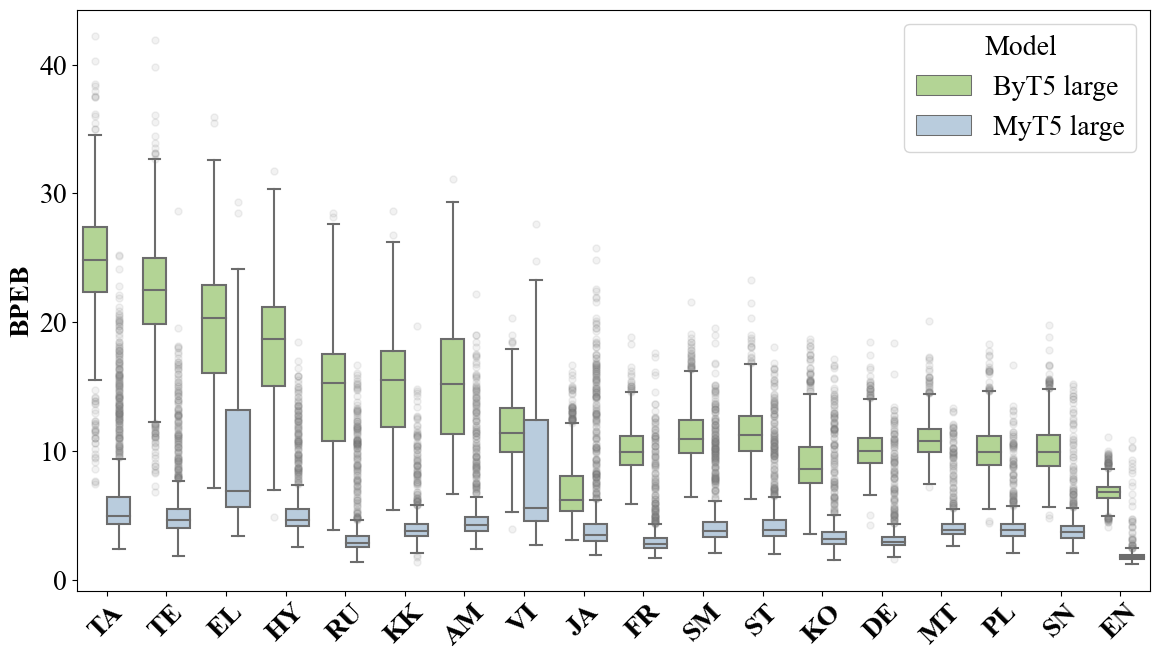

In [103]:
plot_score_across_languages(bpeb, "BPEB", "large_bpeb_boxplot", y_logscale=False, violin=False, languages=language_sample)

<Figure size 1200x600 with 0 Axes>

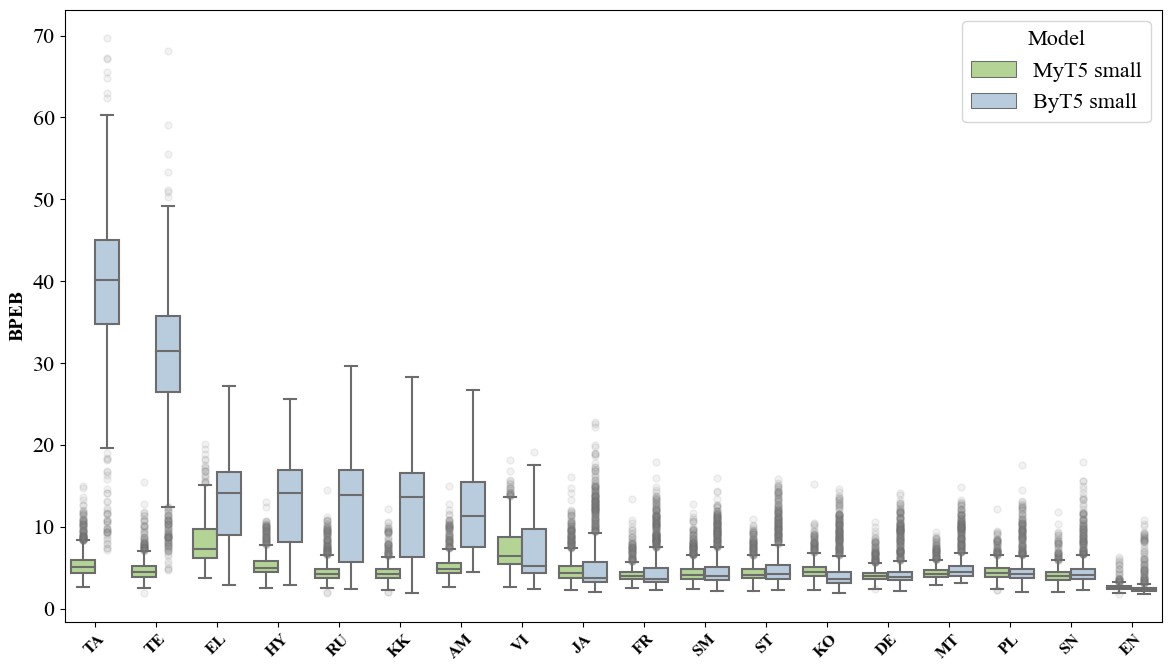

In [46]:
plot_score_across_languages(bpeb, "BPEB", "small_bpeb_boxplot", y_logscale=False, violin=False, languages=language_sample, models=("byt5_small", "myt5_small"))

<Figure size 1200x600 with 0 Axes>

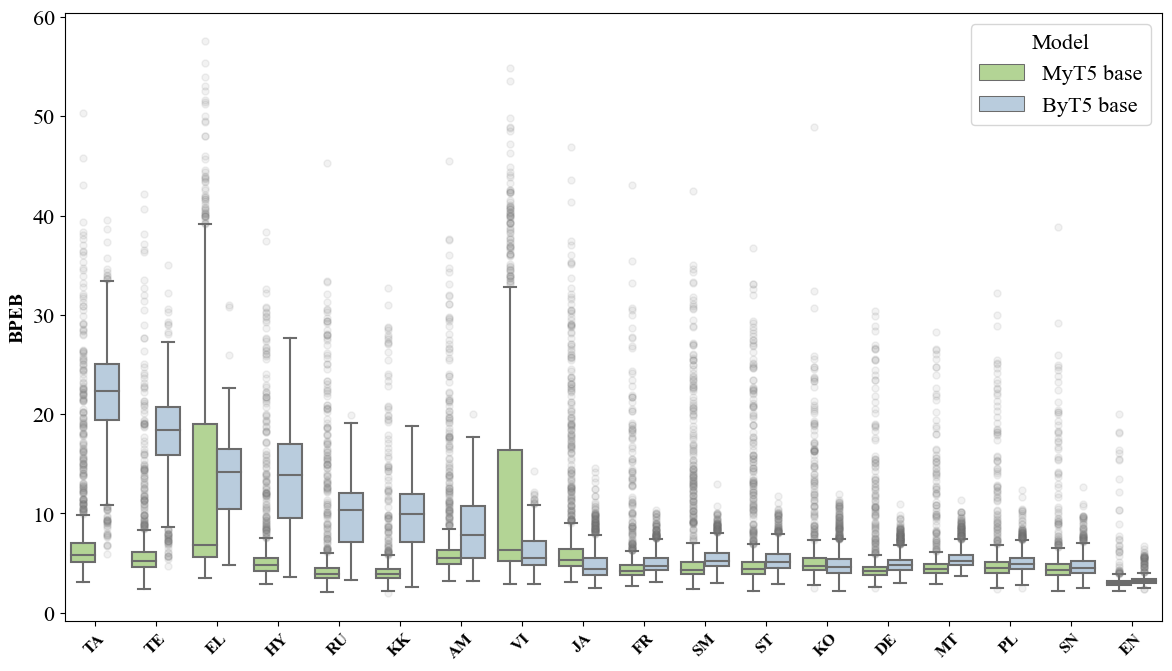

In [47]:
plot_score_across_languages(bpeb, "BPEB", "base_bpeb_boxplot", y_logscale=False, violin=False, languages=language_sample, models=("byt5_base", "myt5_base"))

<Figure size 1200x600 with 0 Axes>

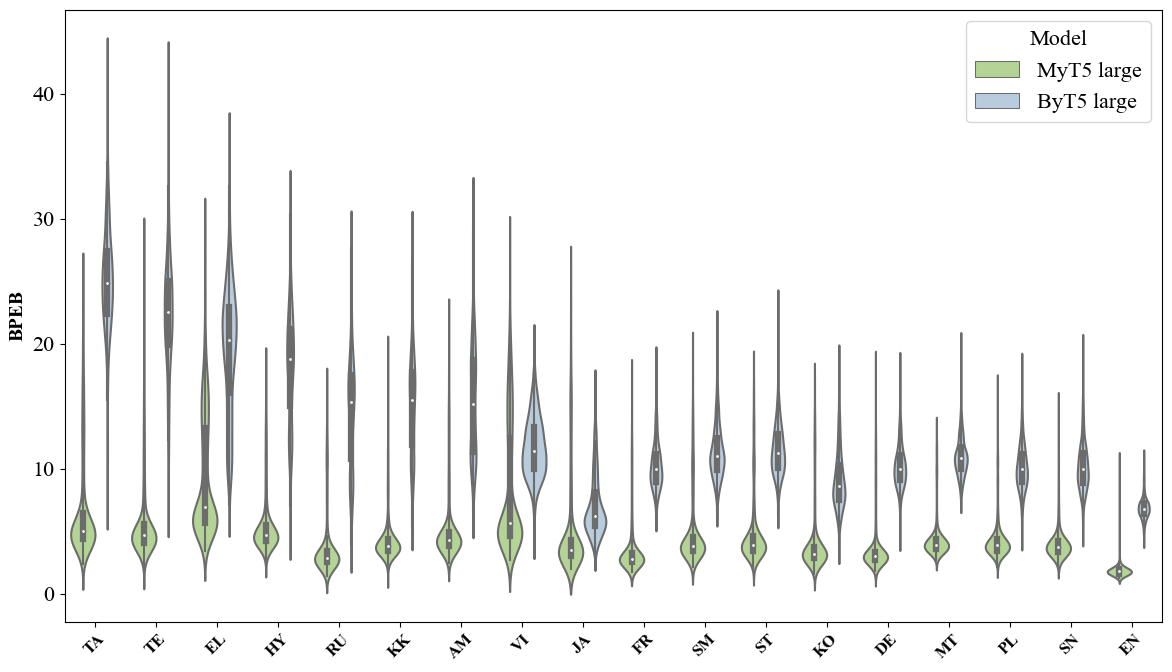

In [48]:
plot_score_across_languages(bpeb, "BPEB", "large_bpeb_violinplot", y_logscale=False, violin=True, languages=language_sample)

## Unssen Languages

In [89]:
bpeb

,Language,Model,BPEB
0,en,myt5_small,3.098666
1,en,myt5_small,2.469221
2,en,myt5_small,2.579489
3,en,myt5_small,4.842084
4,en,myt5_small,2.564179
...,...,...,...
97147,st,byt5_large,9.812580
97148,st,byt5_large,15.245174
97149,st,byt5_large,14.000716
97150,st,byt5_large,13.612420


In [92]:
bpeb_unseen[::-1]

,Language,Model,BPEB
7083,eo,byt5_large,7.807247
7082,eo,byt5_large,9.089616
7081,eo,byt5_large,9.667992
7080,eo,byt5_large,10.183105
7079,eo,byt5_large,9.504107
...,...,...,...
4,en,myt5_large,1.658151
3,en,myt5_large,8.738936
2,en,myt5_large,1.523807
1,en,myt5_large,1.612244


In [74]:
list(bpeb_unseen_avg.Language)

['aeb',
 'ast',
 'eo',
 'sa',
 'sal',
 'war',
 'aeb',
 'ast',
 'eo',
 'sa',
 'sal',
 'war']

<Figure size 1200x600 with 0 Axes>

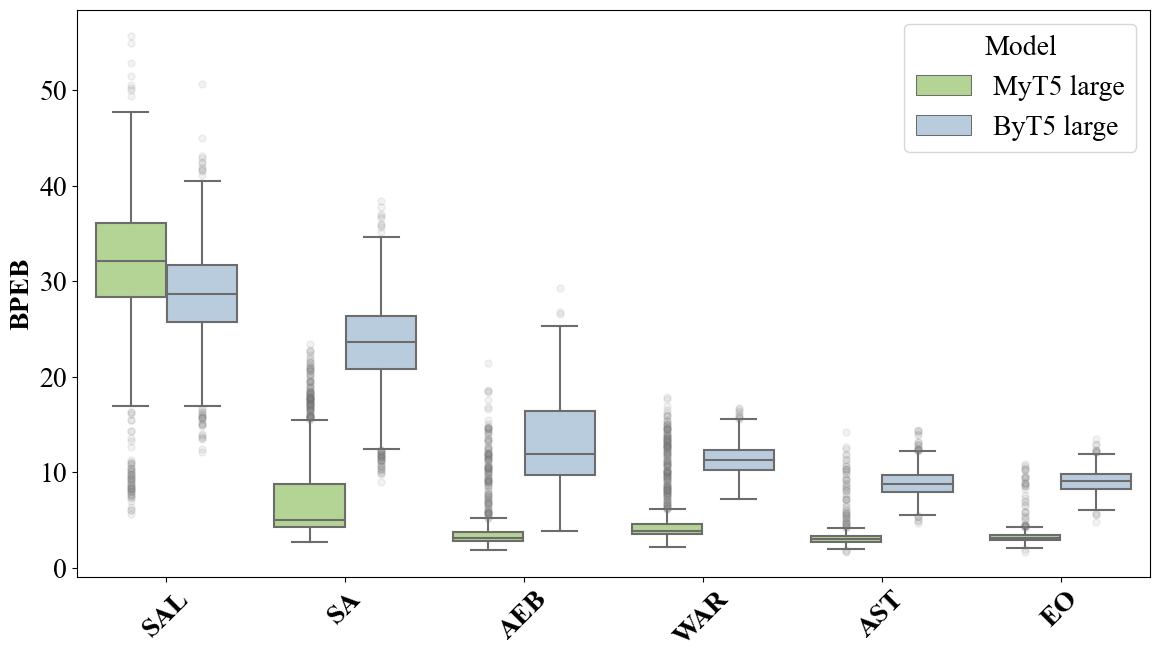

In [104]:
plot_score_across_languages(bpeb_unseen[::-1], "BPEB", "large_bpeb_unseen_boxplot", y_logscale=False, violin=False, models=("myt5_large", "byt5_large"),
                            languages=['sal', 'sa', 'aeb', 'war', 'ast', 'eo'])

## Delta plot

In [21]:
language_sample_small = ['ta', 'te', 'el', 'hy', 'ru', 'am', 'vi', 'ja', 'mt', 'sn', 'en']

In [14]:
def plot_delta(bpeb_avg, comp_avg,save_file=None, pos='myt5_large', neg='byt5_large',y_label="BPEB", language_sample=language_sample, show_legend=True):
    plt.subplots(figsize=(6, 6))


    delta = bpeb_avg[bpeb_avg.Model == pos][y_label].values - bpeb_avg[bpeb_avg.Model == neg][y_label].values
    compression = 1. - comp_avg[comp_avg.Model == pos]["Compressions"].values
    languages = comp_avg[comp_avg.Model == pos]["Language"].values
    # plot with colors by script
    plt.scatter(compression, delta, c=language_all_colors, s=40., alpha=0.4)
    plt.gca().set_xlabel('Compression Factor')
    plt.gca().set_ylabel(r'$\Delta$ BPEB')

    for script in ['Latin', 'Alphabetic', 'Abjad', 'Abugida N', 'Abugida S', 'CJK', 'Other']:
        plt.scatter([], [], color=category_colors[script], label=script, alpha=0.4)
    if show_legend:
        plt.legend()
    
    
    plt.axhline(y=0, color='grey', linestyle=':', alpha=0.3)
    
    
    for i, language in enumerate(languages):
        if language in language_sample:
            plt.gca().annotate(language, (compression[i], delta[i]), alpha=0.7, size=12,
                              xytext=(20, 15), textcoords='offset points', 
                              arrowprops=dict(arrowstyle="->", alpha=0.3))


    if save_file:
        plt.tight_layout()
        plt.savefig(f"output/{save_file}.png", dpi=300)
    plt.show()
    # print pearson and spearman correlation
    print(f"Pearson correlation: {stats.pearsonr(compression, delta)[0]:.2f}")
    print(f"Spearman correlation: {stats.spearmanr(compression, delta)[0]:.2f}")


In [15]:
print(language_sample)

['ta', 'te', 'el', 'hy', 'ru', 'kk', 'am', 'vi', 'ja', 'fr', 'sm', 'st', 'ko', 'de', 'mt', 'pl', 'sn', 'en']


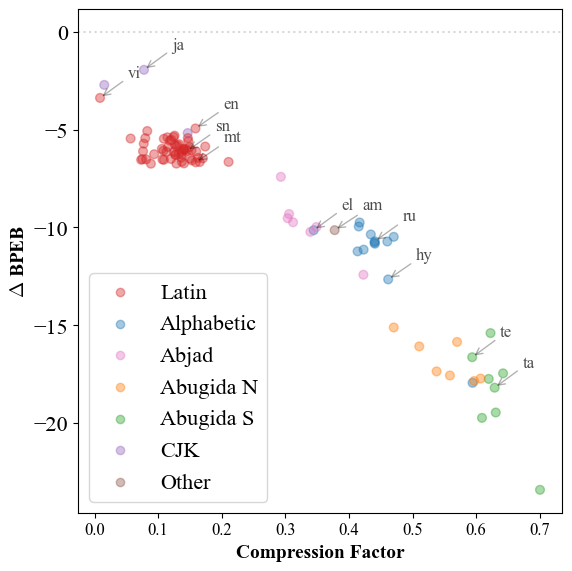

Pearson correlation: -0.96
Spearman correlation: -0.81


In [16]:
plot_delta(bpeb_avg, comp_avg, "large_delta", language_sample=language_sample_small)

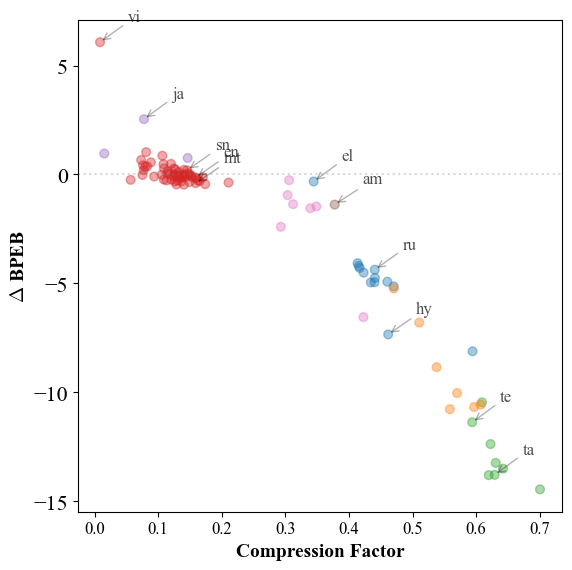

Pearson correlation: -0.94
Spearman correlation: -0.89


In [17]:
plot_delta(bpeb_avg, comp_avg, "base_delta",'myt5_base','byt5_base', language_sample=language_sample_small, show_legend=False)

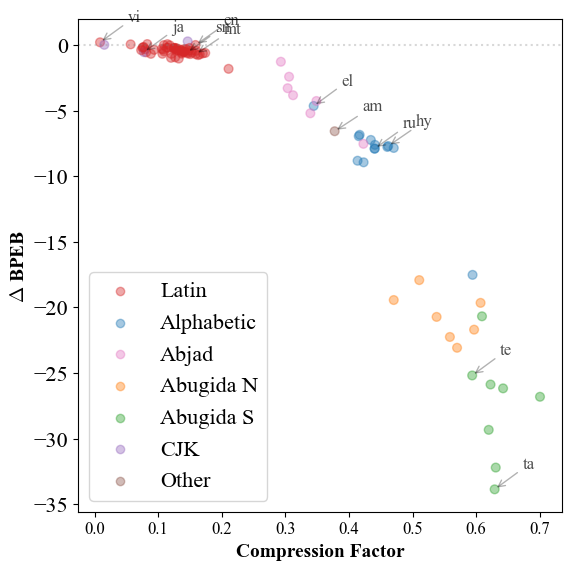

Pearson correlation: -0.92
Spearman correlation: -0.87


In [18]:
plot_delta(bpeb_avg, comp_avg, "small_delta",'myt5_small','byt5_small', language_sample=language_sample_small)

## Plot Times

In [19]:
def plot_time_delta(times_avg, comp_avg,save_file=None, pos='myt5_large', neg='byt5_large',y_label="Time", language_sample=language_sample, show_legend=True):
    plt.subplots(figsize=(6, 6))


    delta = (times_avg[times_avg.Model == pos][y_label].values - times_avg[times_avg.Model == neg][y_label].values) * 1000.
    compression = 1. - comp_avg[comp_avg.Model == pos]["Compressions"].values
    languages = comp_avg[comp_avg.Model == pos]["Language"].values
    # plot with colors by script
    plt.scatter(compression, delta, c=language_all_colors, s=40., alpha=0.4)
    plt.gca().set_xlabel('Compression Factor')
    plt.gca().set_ylabel(r'$\Delta$ Time (ms)')

    for script in ['Latin', 'Alphabetic', 'Abjad', 'Abugida N', 'Abugida S', 'CJK', 'Other']:
        plt.scatter([], [], color=category_colors[script], label=script, alpha=0.4)
    if show_legend:
        plt.legend()
    
    
    plt.axhline(y=0, color='grey', linestyle=':', alpha=0.3)
    
    
    for i, language in enumerate(languages):
        if language in language_sample:
            plt.gca().annotate(language, (compression[i], delta[i]), alpha=0.7, size=12,
                              xytext=(20, 15), textcoords='offset points', 
                              arrowprops=dict(arrowstyle="->", alpha=0.3))


    if save_file:
        plt.tight_layout()
        plt.savefig(f"output/{save_file}.png", dpi=300)
    plt.show()
    # print pearson and spearman correlation
    print(f"Pearson correlation: {stats.pearsonr(compression, delta)[0]:.2f}")
    print(f"Spearman correlation: {stats.spearmanr(compression, delta)[0]:.2f}")


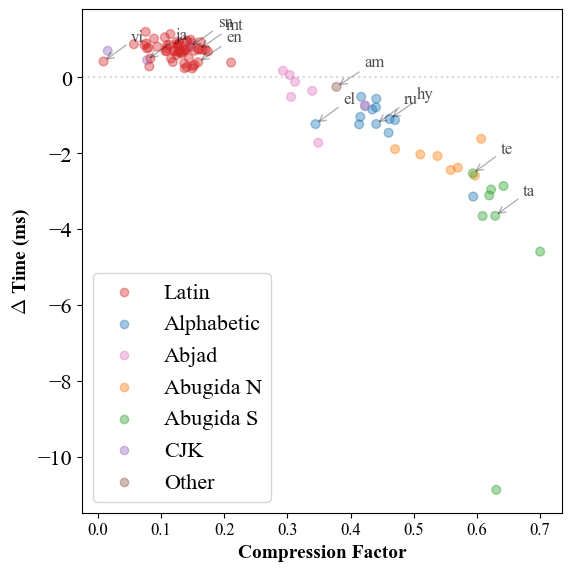

Pearson correlation: -0.85
Spearman correlation: -0.79


In [20]:
plot_time_delta(times_avg, comp_avg, "small_time_delta",'myt5_small','byt5_small', language_sample=language_sample_small)

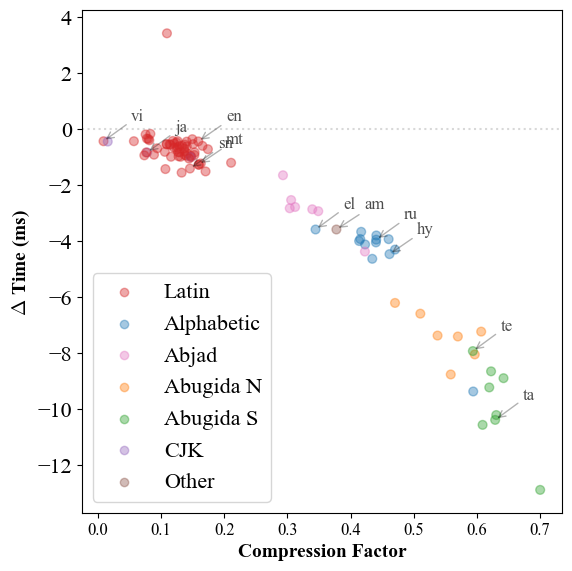

Pearson correlation: -0.95
Spearman correlation: -0.87


In [21]:
plot_time_delta(times_avg, comp_avg, "base_time_delta",'myt5_base','byt5_base', language_sample=language_sample_small)

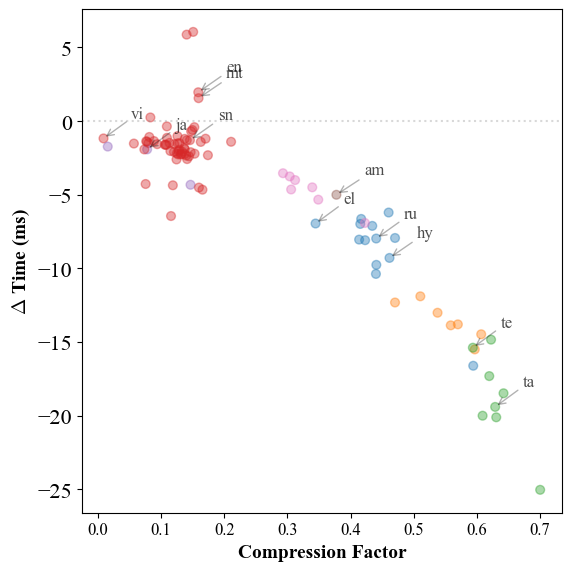

Pearson correlation: -0.91
Spearman correlation: -0.75


In [22]:
plot_time_delta(times_avg, comp_avg, "large_time_delta",'myt5_large','byt5_large', language_sample=language_sample_small, show_legend=False)

## Table for all models

## Table for all models

In [23]:


def aggregate_results(bpeb_avg, times_avg, save_file=None):
    df = pd.merge(bpeb_avg, times_avg, on=['Language', 'Model'], how='outer')
    
    df = pd.merge(bpeb_avg, times_avg, on=['Language', 'Model'], how='outer')
    df[['Model', 'Size']] = df['Model'].str.split('_', n=1, expand=True)
    df_my = df[df.Model == 'myt5']
    df_by = df[df.Model == 'byt5']
    
    df_my[('myt5', 'BPEB')] = df_my["BPEB"]
    df_my[('myt5', 'Time (ms)')] = df_my["Time"] * 1000
    
    df_by[('byt5', 'BPEB')] = df_by["BPEB"]
    df_by[('byt5', 'Time (ms)')] = df_by["Time"] * 1000
    df_my.drop(["Model", "BPEB", "Time"], axis=1, inplace=True)
    df_by.drop(["Model", "BPEB", "Time"], axis=1, inplace=True)
    
    df = pd.merge(df_by, df_my, on=['Language', 'Size'], how='outer')


    df['group'] = df['Language'].map(lambda l: language_groups[l])

    
    group_avg = df.drop("group", axis=1).groupby('Size').mean()
    size_avg = df.groupby(['Size', 'group']).mean()
    
    df_avg = pd.concat([size_avg, group_avg])
    df_avg.columns =  pd.MultiIndex.from_tuples(df_avg.columns)
    df_avg.index  = df_avg.index.map(lambda x: (x, "All") if type(x)!=tuple else x)
    df_avg.sort_index(inplace=True)
    df_avg.index =  pd.MultiIndex.from_tuples(df_avg.index)
    if save_file:
        df_avg.to_latex(f"output/{save_file}.tex", float_format="%.1f", label=save_file)
    print(df_avg)

In [24]:
aggregate_results(bpeb_avg, times_avg, "modeling_scales")

                      byt5                 myt5           
                      BPEB  Time (ms)      BPEB  Time (ms)
base  All         8.213647  11.503080  5.789164   8.868982
      Latin       4.922813   9.382542  5.038525   8.697370
      Non Latin  13.023327  14.602327  6.886251   9.119799
large All        13.374591  31.832597  4.584978  26.735016
      Latin      10.062638  28.094840  4.046870  26.582901
      Non Latin  18.215139  37.295473  5.371444  26.957337
small All        10.102284   6.954234  4.561977   6.682153
      Latin       4.629357   5.876137  4.196619   6.575219
      Non Latin  18.101179   8.529913  5.095962   6.838441


/var/folders/9n/nnn8h5vs5sg4nqlp3t2w_q480000gn/T/ipykernel_58503/2609557932.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_my[('myt5', 'BPEB')] = df_my["BPEB"]
/var/folders/9n/nnn8h5vs5sg4nqlp3t2w_q480000gn/T/ipykernel_58503/2609557932.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_my[('myt5', 'Time (ms)')] = df_my["Time"] * 1000
/var/folders/9n/nnn8h5vs5sg4nqlp3t2w_q480000gn/T/ipykernel_58503/2609557932.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [25]:
['small', 'base', 'large'].index('base')

1

## Table with results for each language

In [26]:
def results_per_language(bpeb_avg, times_avg, save_file=None):

    # plot table with results for each column in rows
    df = pd.merge(bpeb_avg, times_avg, on=['Language', 'Model'], how='outer')
    df[['Model', 'Size']] = df['Model'].str.split('_', n=1, expand=True)

    df_my = df[df.Model == 'myt5']
    df_by = df[df.Model == 'byt5']

    df_my[('myt5', 'BPEB')] = df_my["BPEB"]
    df_my[('myt5', 'Time (ms)')] = df_my["Time"] * 1000

    df_by[('byt5', 'BPEB')] = df_by["BPEB"]
    df_by[('byt5', 'Time (ms)')] = df_by["Time"] * 1000
    df_my.drop(["Model", "BPEB", "Time"], axis=1, inplace=True)
    df_by.drop(["Model", "BPEB", "Time"], axis=1, inplace=True)

    df = pd.merge(df_by, df_my, on=['Language', 'Size'], how='outer')
    df['Size'] = pd.Categorical(df['Size'], ('small', 'base', 'large'))
    df.sort_values("Size", inplace=True)
    
    df = df.pivot(index='Language', columns='Size')
    
    

    
    if save_file:
        df.to_latex(f"output/{save_file}.tex", float_format="%.1f", label=save_file)
    print(df)
    return df


In [27]:
df_modeling = results_per_language(bpeb_avg, times_avg, "modeling_per_language")

         (byt5, BPEB)                       (byt5, Time (ms))             \
Size            small       base      large             small       base   
Language                                                                   
af           3.905785   4.622249   9.549270          5.782168   8.943027   
am          11.708136   8.304133  15.317867          6.912414  12.538772   
ar           7.038655   6.681192  13.684116          6.956901  11.619133   
az           6.421698   5.726190  11.375850          6.324210   9.926520   
be          14.551806  11.584020  17.076150          8.108961  13.500242   
...               ...        ...        ...               ...        ...   
xh           4.359740   4.544732   9.926304          5.532694   9.432825   
yi          12.503633  13.184510  18.143062          7.429785  13.538989   
yo           6.297595   6.305914  11.910816          6.246283   9.975901   
zh           3.413901   3.976095   6.049610          5.623281   8.645855   
zu          

/var/folders/9n/nnn8h5vs5sg4nqlp3t2w_q480000gn/T/ipykernel_58503/3786957012.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_my[('myt5', 'BPEB')] = df_my["BPEB"]
/var/folders/9n/nnn8h5vs5sg4nqlp3t2w_q480000gn/T/ipykernel_58503/3786957012.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_my[('myt5', 'Time (ms)')] = df_my["Time"] * 1000
/var/folders/9n/nnn8h5vs5sg4nqlp3t2w_q480000gn/T/ipykernel_58503/3786957012.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [28]:
## load dataframe from latex
df_parities = pd.read_csv("output/parities_per_language.csv", sep="\t").set_index("Language")
df_merged = pd.merge(df_parities, df_modeling, how='right', left_index=True, right_index=True)
df_merged[" Compression"] = df_merged[" Compression"] * 100.
df_merged.to_latex(f"output/results_per_language.tex", float_format="%.1f", label="results_per_language")

/var/folders/9n/nnn8h5vs5sg4nqlp3t2w_q480000gn/T/ipykernel_58503/1241303560.py:3: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  df_merged = pd.merge(df_parities, df_modeling, how='right', left_index=True, right_index=True)
/var/folders/9n/nnn8h5vs5sg4nqlp3t2w_q480000gn/T/ipykernel_58503/1241303560.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_merged.to_latex(f"output/results_per_language.tex", float_format="%.1f", label="results_per_language")


In [29]:
df_merged

,Byte Parity,Byte Length,Myte Parity,Myte Length,Compression,"((byt5, BPEB), small)","((byt5, BPEB), base)","((byt5, BPEB), large)","((byt5, Time (ms)), small)","((byt5, Time (ms)), base)","((byt5, Time (ms)), large)","((myt5, BPEB), small)","((myt5, BPEB), base)","((myt5, BPEB), large)","((myt5, Time (ms)), small)","((myt5, Time (ms)), base)","((myt5, Time (ms)), large)"
Language,,,,,,,,,,,,,,,,,
af,1.069624,139.617589,1.130167,123.346838,11.653797,3.905785,4.622249,9.549270,5.782168,8.943027,27.599026,3.691089,4.349194,3.419689,6.635912,8.400354,26.116881
am,1.706713,222.776680,1.261132,137.640316,38.216012,11.708136,8.304133,15.317867,6.912414,12.538772,32.004675,5.134385,6.922951,5.178775,6.656394,8.956238,26.998942
ar,1.599413,208.770751,1.321485,144.227273,30.915958,7.038655,6.681192,13.684116,6.956901,11.619133,31.368843,4.618001,6.421677,4.369476,6.437272,9.087048,26.723209
az,1.261143,164.616601,1.182544,129.063241,21.597676,6.421698,5.726190,11.375850,6.324210,9.926520,28.869938,4.603050,5.354095,4.728042,6.709211,8.724977,27.462287
be,2.050925,267.706522,1.425025,155.527668,41.903669,14.551806,11.584020,17.076150,8.108961,13.500242,35.462835,5.730430,7.515356,5.852828,6.865343,9.506560,27.413691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xh,1.054127,137.594862,1.054006,115.034585,16.396162,4.359740,4.544732,9.926304,5.532694,9.432825,30.150267,3.914145,4.381219,3.809767,6.276095,8.158115,25.633829
yi,1.944154,253.769763,1.334387,145.635375,42.611218,12.503633,13.184510,18.143062,7.429785,13.538989,34.094553,4.970421,6.641524,5.724052,6.697083,9.168167,27.173761
yo,1.278290,166.854743,1.326890,144.817194,13.207625,6.297595,6.305914,11.910816,6.246283,9.975901,29.017476,5.318918,6.793299,5.412731,6.936569,9.314118,26.920604
